In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import user, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

import acquire as a

## Using saas.csv or log data from API usage



In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
a.check_columns(df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
3,Subscription_Type,5,"[0.0, 2.0, 1.0, 4.0, 3.0]",0,0.0,float64
4,Amount,5,"[0.0, 10.0, 5.0, 20.0, 15.0]",0,0.0,float64
0,Month_Invoiced,48,"[2014-01-31, 2014-02-28, 2014-03-31, 2014-04-3...",0,0.0,object
1,Customer_Id,29400,"[1000000, 1000001, 1000002, 1000003, 1000004, ...",0,0.0,int64
2,Invoice_Id,790458,"[5000000, 5000001, 5000002, 5000003, 5000004, ...",0,0.0,int64


In [5]:
# lowercase column names
df.columns = df.columns.str.lower()

In [6]:
df.shape

(790458, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   month_invoiced     790458 non-null  object 
 1   customer_id        790458 non-null  int64  
 2   invoice_id         790458 non-null  int64  
 3   subscription_type  790458 non-null  float64
 4   amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


### No nulls, Change month_invoiced into datetime

In [8]:
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   month_invoiced     790458 non-null  datetime64[ns]
 1   customer_id        790458 non-null  int64         
 2   invoice_id         790458 non-null  int64         
 3   subscription_type  790458 non-null  float64       
 4   amount             790458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 30.2 MB


In [10]:
df = df.set_index('month_invoiced').sort_index()

In [11]:
df.shape

(790458, 4)

## Target Variables are Sub type and Amount

In [12]:
df_resampled = df.resample('M')[['subscription_type', 'amount']].sum()

In [13]:
df_resampled.shape

(48, 2)

In [14]:
df_resampled.head(3)

,subscription_type,amount
month_invoiced,,
2014-01-31,7170.0,35850.0
2014-02-28,7438.0,37190.0
2014-03-31,7659.0,38295.0


### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.


In [15]:
# take 50% of our data for train (round to integer for a whole number)
train_size = int(.5 * len(df_resampled))
# take 30% for validation
validate_size = int(len(df_resampled) * .3)
# get the remainder or rows for test
test_size = int(len(df_resampled) - train_size - validate_size)
# get the delineation point between validate and test by summing train and validate
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [16]:
train.shape[0] + validate.shape[0] + test.shape[0]

48

### 2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
* Last Observed Value
* Simple Average
* Moving Average
* Holt's Linear Trend
* Holt's Seasonal Trend
* Based on previous year/month/etc., this is up to you.


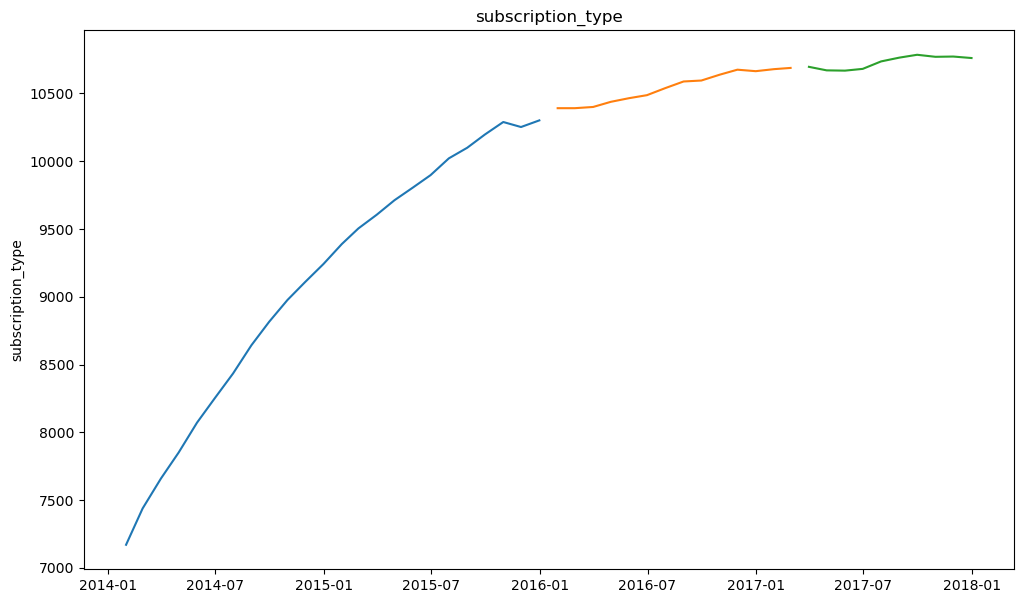

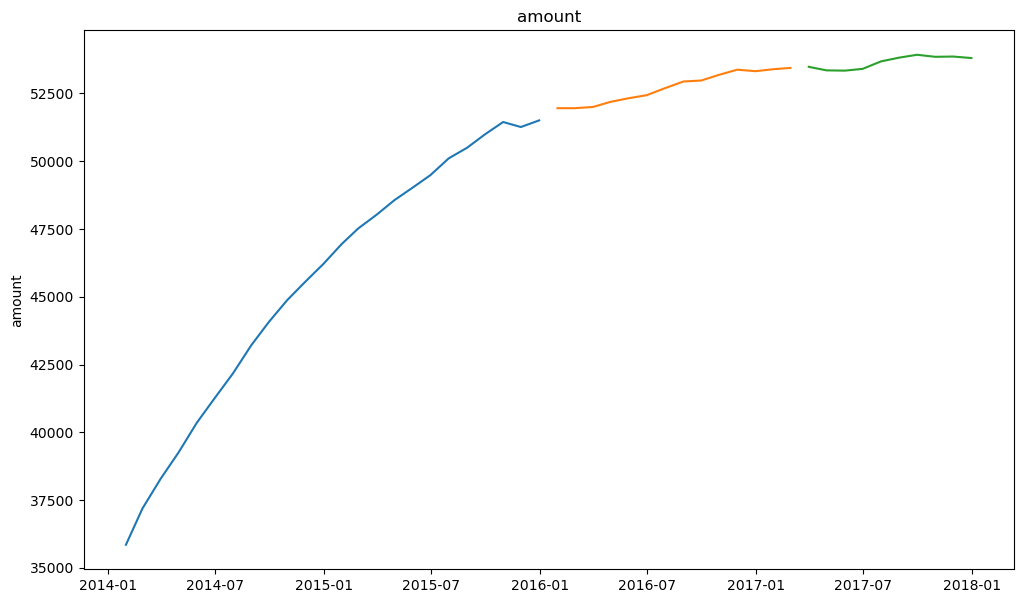

In [17]:
# plotting the values of quantity and sales over time by data subset:
for col in train.columns:
    plt.figure(figsize=(12,7))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [18]:
# evaluation function to compute rmse
# calculate an error metric on the validation's target versus predictions
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

In [19]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.show()

In [20]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [21]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

## Last Observed Value

In [22]:
train['amount'][-1:][0]

51505.0

In [23]:

# take the last item of amount and assign to variable
last_amount = train['amount'][-1:][0]

# take the last item of subscription_type and assign to variable
last_subtype = train['subscription_type'][-1:][0]

# let's make the prediction dataframe 
yhat_df = pd.DataFrame(
    {
    'amount': [last_amount],
    'subscription_type': [last_subtype]
    },
    index = validate.index
)

In [24]:
yhat_df.head()

,amount,subscription_type
month_invoiced,,
2016-01-31,51505.0,10301.0
2016-02-29,51505.0,10301.0
2016-03-31,51505.0,10301.0
2016-04-30,51505.0,10301.0
2016-05-31,51505.0,10301.0


### Plot Actual vs. Predicted Values

subscription_type -- rmse: 269.0


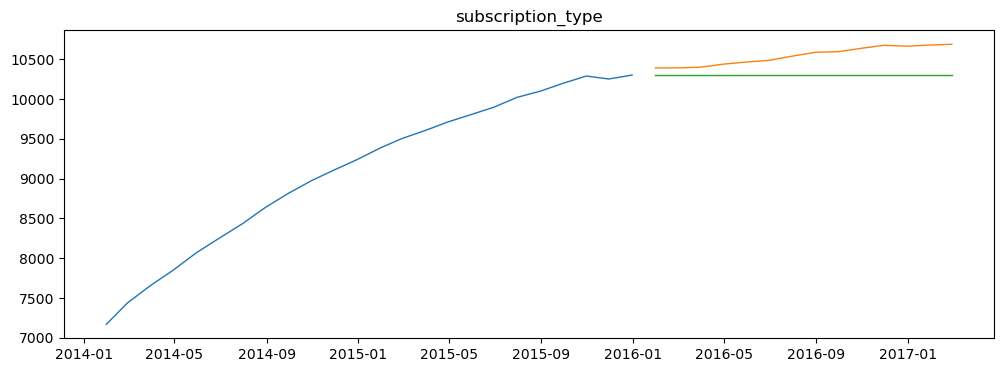

amount -- rmse: 1343.0


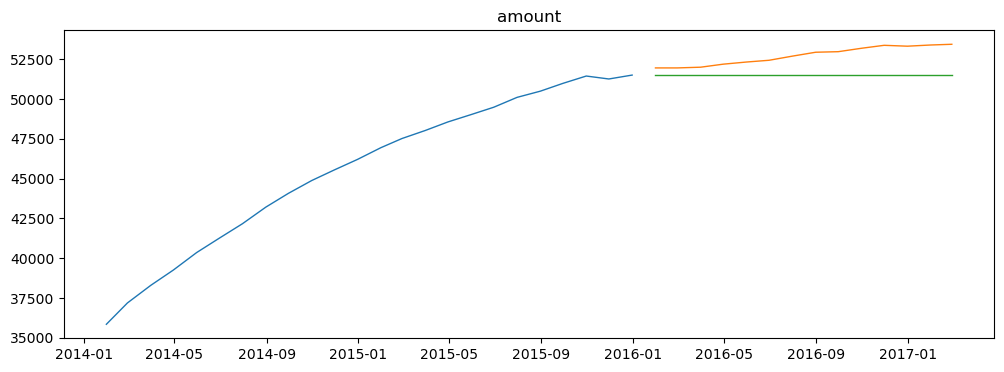

In [25]:
# use the plot and eval function we defined earlier for both targets:
for col in train.columns:
    plot_and_eval(col)

### Evaluate

In [26]:
eval_df

,model_type,target_var,rmse


In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                             target_var=col)

In [28]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,subscription_type,269.0
0,last_observed_value,amount,1343.0


## Simple Average

In [29]:
# compute simple average of amount (from train data)
avg_amount = round(train['amount'].mean(), 2)

# compute simple average of quantity (from train data)
avg_subtype = round(train['subscription_type'].mean(), 2)


yhat_df = pd.DataFrame({'amount': [avg_amount],
                        'subscription_type': [avg_subtype]},
                        index=validate.index)

yhat_df.head(3)

,amount,subscription_type
month_invoiced,,
2016-01-31,45568.54,9113.71
2016-02-29,45568.54,9113.71
2016-03-31,45568.54,9113.71


### Plot Actual vs. Predicted Values

subscription_type -- rmse: 1436.0


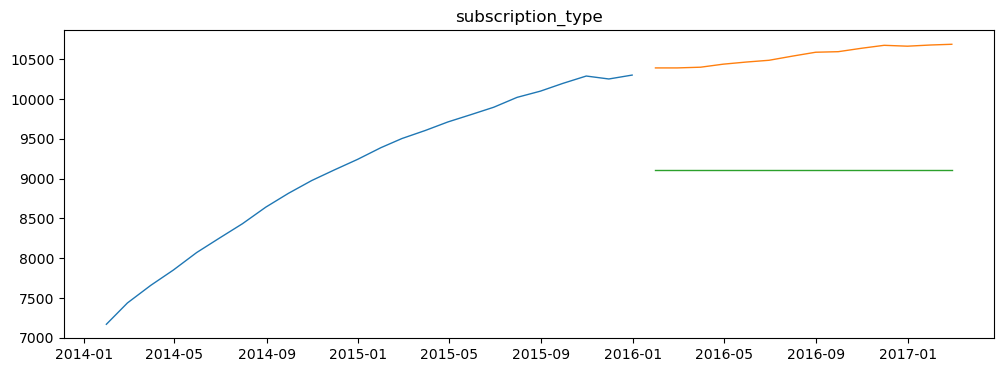

amount -- rmse: 7181.0


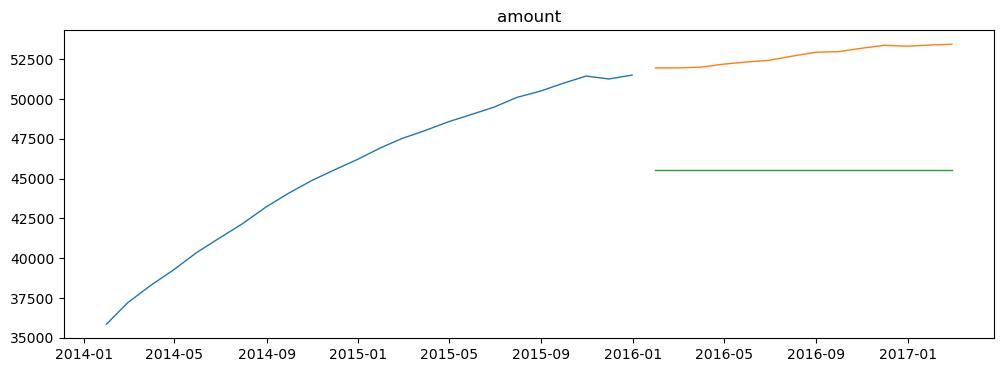

In [30]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate

In [31]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,subscription_type,269.0
0,last_observed_value,amount,1343.0
0,simple_average,subscription_type,1436.0
0,simple_average,amount,7181.0


## Moving Average

In [32]:
# compute a 12 month rolling average, 
# use the most recent/last 12 month period value to predict forward. 

period = 12

rolling_amount = round(
    train['amount'].rolling(period).mean()[-1], 2)
rolling_subtype = round(
    train['subscription_type'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': rolling_amount,
                        'subscription_type': rolling_subtype},
                         index=validate.index)
yhat_df.head()

,amount,subscription_type
month_invoiced,,
2016-01-31,49612.92,9922.58
2016-02-29,49612.92,9922.58
2016-03-31,49612.92,9922.58
2016-04-30,49612.92,9922.58
2016-05-31,49612.92,9922.58


### Plot Actual vs. Predicted Values

subscription_type -- rmse: 633.0


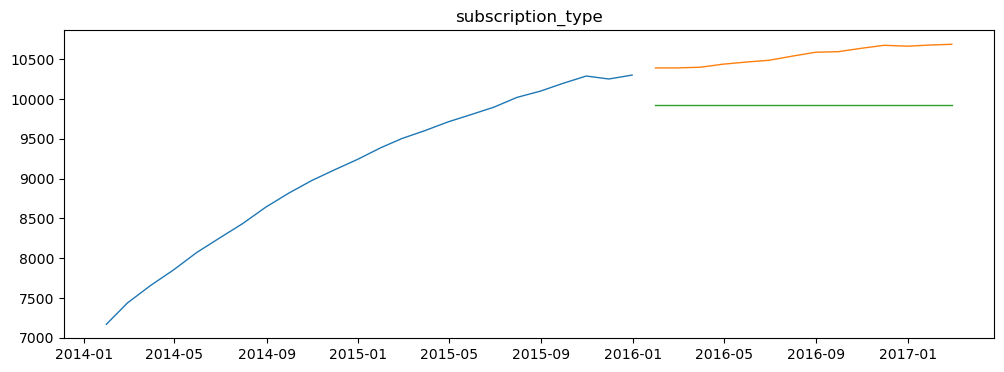

amount -- rmse: 3164.0


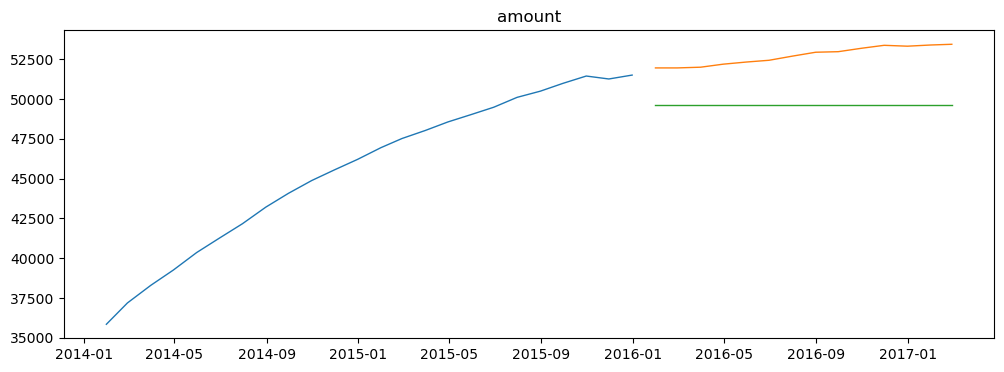

In [33]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate

In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type='12m moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,subscription_type,269.0
0,last_observed_value,amount,1343.0
0,simple_average,subscription_type,1436.0
0,simple_average,amount,7181.0
0,12m moving average,subscription_type,633.0
0,12m moving average,amount,3164.0


In [35]:
periods = [6, 24]

for p in periods: 
    rolling_amount = round(
    train['amount'].rolling(p).mean()[-1], 2)
    rolling_subtype = round(
    train['subscription_type'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame(
        {
            'amount' : [rolling_amount],
            'subscription_type': [rolling_subtype]
        },
        index=validate.index
    )
    model_type = str(p) + '_month_moving_avg'
    # lets update the eval_df (remember we have two targets!)
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col)

In [36]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,subscription_type,269.0
0,last_observed_value,amount,1343.0
0,simple_average,subscription_type,1436.0
0,simple_average,amount,7181.0
0,12m moving average,subscription_type,633.0
0,12m moving average,amount,3164.0
0,6_month_moving_avg,subscription_type,369.0
0,6_month_moving_avg,amount,1847.0
0,24_month_moving_avg,subscription_type,1436.0
0,24_month_moving_avg,amount,7181.0


## Which is the best so far?

In [37]:
eval_df.groupby('target_var')['rmse'].min()

target_var
amount               1343.0
subscription_type     269.0
Name: rmse, dtype: float64

In [38]:
# get the min rmse for each variable

min_rmse_amount = eval_df.groupby(
    'target_var')['rmse'].min()[1]
min_rmse_subtype = eval_df.groupby(
    'target_var')['rmse'].min()[0]

In [39]:
eval_df[(eval_df.rmse == min_rmse_amount) | 
       (eval_df.rmse == min_rmse_subtype)]

,model_type,target_var,rmse
0,last_observed_value,subscription_type,269.0
0,last_observed_value,amount,1343.0


## Holt-Winters

### Seasonal Decomposition

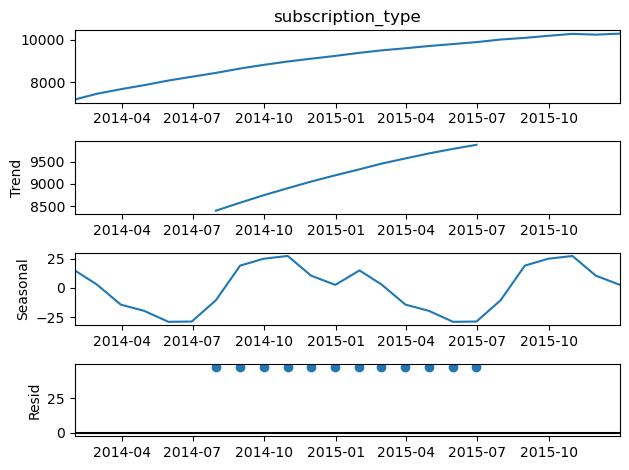

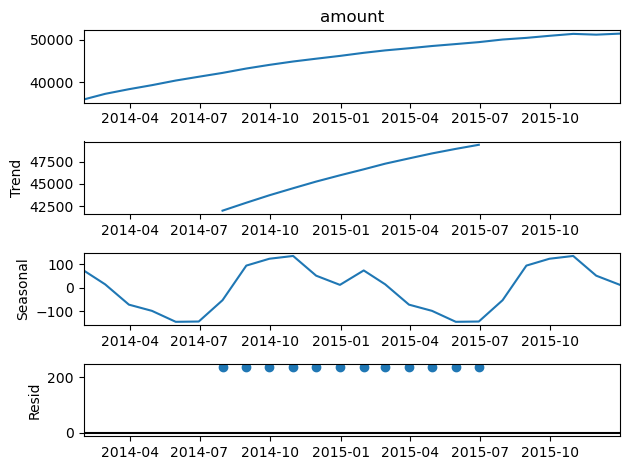

In [40]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()

### Basic Holt's Linear Trend

In [41]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start=validate.index[0],
                                end= validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

In [42]:
yhat_df.head()

,amount,subscription_type
month_invoiced,,
2016-01-31,51748.57,10359.46
2016-02-29,51961.90,10413.64
2016-03-31,52173.21,10464.44
2016-04-30,52382.50,10512.07
2016-05-31,52589.81,10556.74


### Plot Actual vs. Predicted Values

subscription_type -- rmse: 104.0


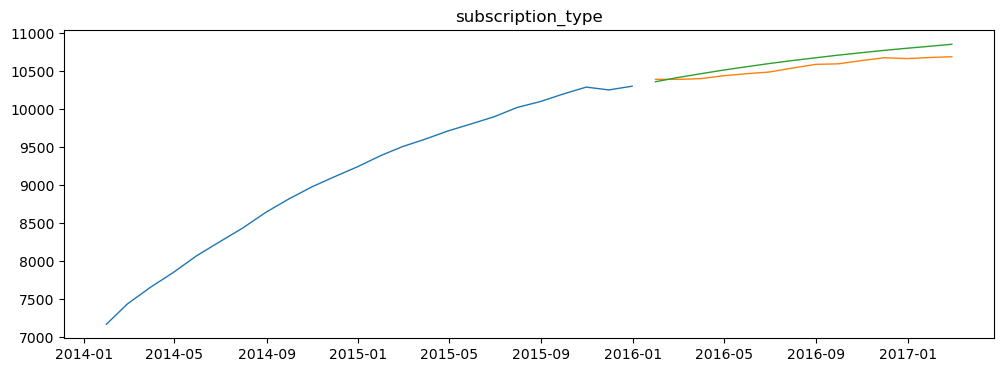

amount -- rmse: 456.0


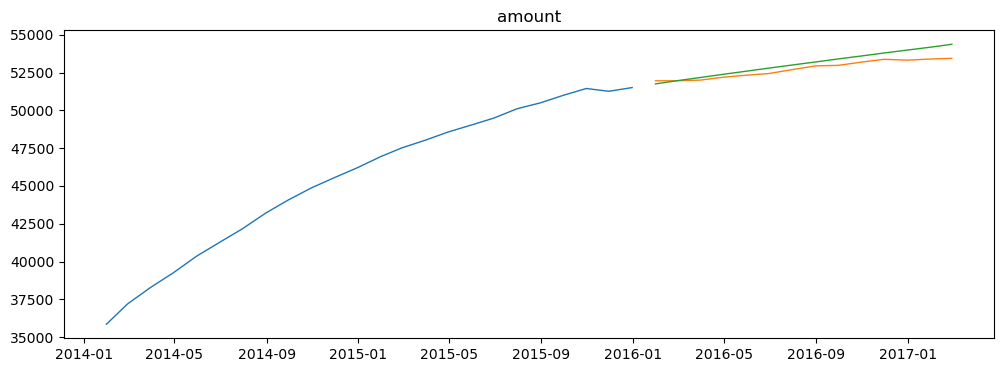

In [43]:
for col in train.columns:
    plot_and_eval(target_var = col)

### Evaluate

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

## Holts Seasonal Trend

In [45]:
import itertools

In [46]:
combos = list(itertools.product(['add','mul'],[True, False]))

In [47]:
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [48]:
# let's play with some hyperparameter combinations:
hsts = {}
for col in train.columns:
    hsts[col] = {}
    for i, combo in enumerate(combos):
        hsts[col]['hst_fit_' + str(i)] = \
        ExponentialSmoothing(train[col],
                            seasonal_periods=12,
                            trend='add',
                            seasonal=combo[0],
                            damped=combo[1]).fit()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [49]:
hsts.keys()

dict_keys(['subscription_type', 'amount'])

In [50]:
hsts['amount']

{'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x177e1b9d0>,
 'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x177e20b10>,
 'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x177e27490>,
 'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x177e60610>}

In [51]:
# compare our scores
best_score = 'placeholder'
for model in hsts['subscription_type']:
    score = sqrt(hsts['subscription_type'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

In [52]:
best_score

{'hst_fit_0': 17.35922506149124}

In [53]:
best_score = 'placeholder'
for model in hsts['amount']:
    score = sqrt(hsts['amount'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] \
        > list(current_model.values())[0]:
            best_score = current_model

In [54]:
best_score

{'hst_fit_0': 401.17629159442976}

### Make Predictions

In [55]:
yhat_df = pd.DataFrame({'amount': hsts['amount']['hst_fit_0'].forecast(validate.shape[0] + 1),
                           'subscription_type': hsts['subscription_type']['hst_fit_0'].forecast(validate.shape[0] + 1)},
                          index=validate.index)
yhat_df

,amount,subscription_type
month_invoiced,,
2016-01-31,51119.814021,10351.239700
2016-02-29,51674.622665,10384.315539
2016-03-31,52262.182190,10398.035938
2016-04-30,52857.516838,10410.648863
2016-05-31,53436.807105,10439.954320
2016-06-30,53826.996353,10457.800644
2016-07-31,54233.864637,10501.572306
2016-08-31,54547.523033,10542.707670
2016-09-30,54796.755091,10583.670585


subscription_type -- rmse: 40.0


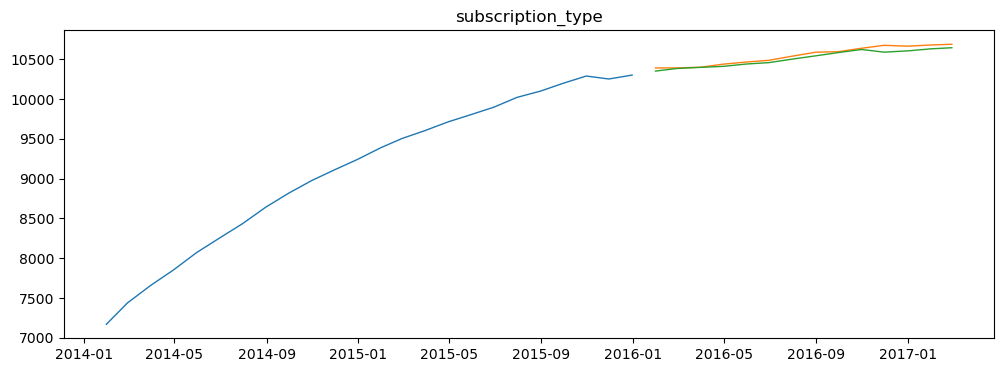

amount -- rmse: 1189.0


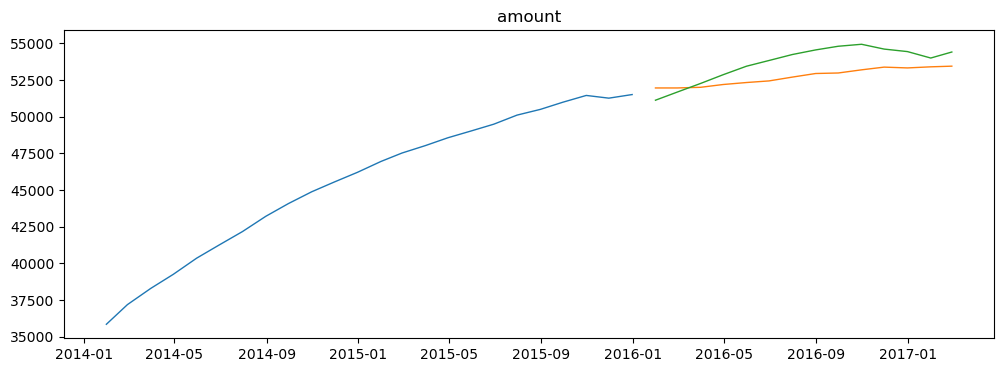

In [56]:
for col in train.columns:
    plot_and_eval(col)

In [57]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [58]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,holts_seasonal,subscription_type,40.0
0,holts_optimized,subscription_type,104.0
0,last_observed_value,subscription_type,269.0
0,6_month_moving_avg,subscription_type,369.0
0,holts_optimized,amount,456.0
0,12m moving average,subscription_type,633.0
0,holts_seasonal,amount,1189.0
0,last_observed_value,amount,1343.0
0,simple_average,subscription_type,1436.0
0,24_month_moving_avg,subscription_type,1436.0


subscription_type -- rmse: 40.0


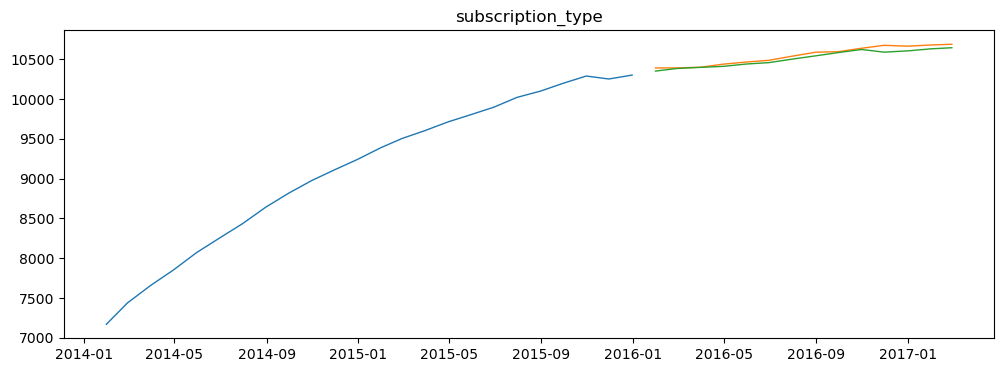

amount -- rmse: 1189.0


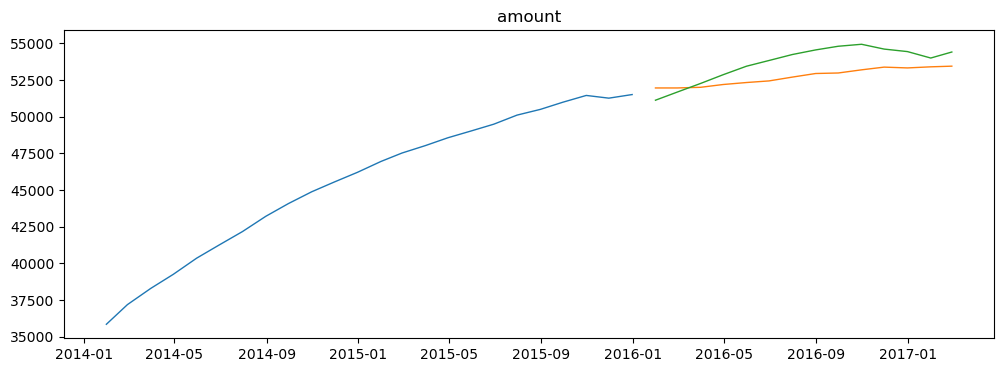

In [59]:
for col in train.columns:
    plot_and_eval(col)

## Which Model Performed the Best?

In [60]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,holts_seasonal,subscription_type,40.0
0,holts_optimized,subscription_type,104.0
0,last_observed_value,subscription_type,269.0
0,6_month_moving_avg,subscription_type,369.0
0,holts_optimized,amount,456.0
0,12m moving average,subscription_type,633.0
0,holts_seasonal,amount,1189.0
0,last_observed_value,amount,1343.0
0,simple_average,subscription_type,1436.0
0,24_month_moving_avg,subscription_type,1436.0


In [61]:
amount_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

subtype_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == amount_min_rmse) | 
         (eval_df.rmse == subtype_min_rmse))]

,model_type,target_var,rmse
0,holts_optimized,amount,456.0
0,holts_seasonal,subscription_type,40.0


## Performance on Test

In [62]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]
train.shape, validate.shape, test.shape

((24, 2), (14, 2), (10, 2))

In [63]:
yhat_df = pd.DataFrame({'amount': hsts['amount']['hst_fit_0'].forecast(validate.shape[0] + test.shape[0] + 1),
                           'subscription_type': hsts['subscription_type']['hst_fit_0'].forecast(validate.shape[0] + test.shape[0] + 1)})
yhat_df

,amount,subscription_type
2016-01-31,51119.814021,10351.239700
2016-02-29,51674.622665,10384.315539
2016-03-31,52262.182190,10398.035938
2016-04-30,52857.516838,10410.648863
2016-05-31,53436.807105,10439.954320
2016-06-30,53826.996353,10457.800644
2016-07-31,54233.864637,10501.572306
2016-08-31,54547.523033,10542.707670
2016-09-30,54796.755091,10583.670585
2016-10-31,54931.557370,10622.467497


In [64]:
test.head(1)

,subscription_type,amount
month_invoiced,,
2017-03-31,10696.0,53480.0


In [65]:
yhat_df = yhat_df['2017-04-30':]

In [66]:
yhat_df.head()

,amount,subscription_type
2017-04-30,55319.333315,10637.133778
2017-05-31,55774.644152,10651.172891
2017-06-30,56047.097692,10654.781908
2017-07-31,56342.159551,10685.275936
2017-08-31,56549.642200,10714.028653


In [67]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-amount:  2521.8520378876906
rmse-subtype:  28.927011374755352


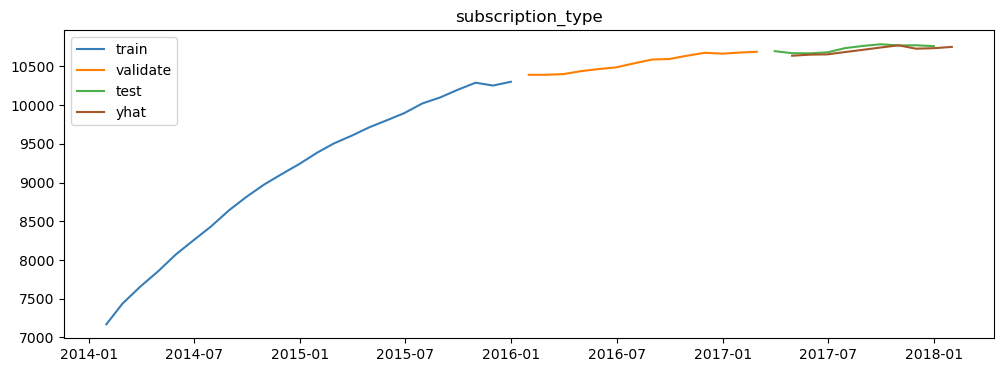

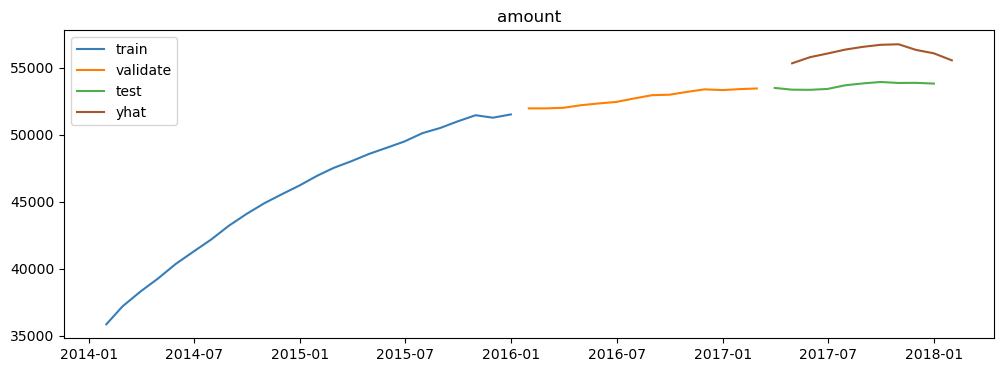

In [68]:
rmse_amount = sqrt(mean_squared_error(test['amount'], 
                                       yhat_df['amount']))

rmse_subtype = sqrt(mean_squared_error(test['subscription_type'], 
                                       yhat_df['subscription_type']))

print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-amount: ', rmse_amount)
print('rmse-subtype: ', rmse_subtype)
for col in train.columns:
    final_plot(col)

## Forecasting

In [72]:
forecast = pd.DataFrame({'amount': hsts['amount']['hst_fit_0'].forecast(validate.shape[0] + test.shape[0] + 1 + 12),
                           'subscription_type': hsts['subscription_type']['hst_fit_0'].forecast(validate.shape[0] + test.shape[0] + 1 + 12)})
# how does forecast look

In [73]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

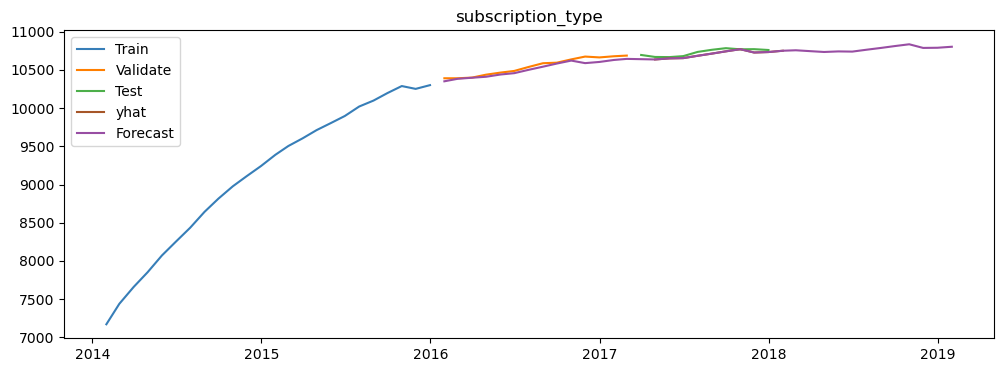

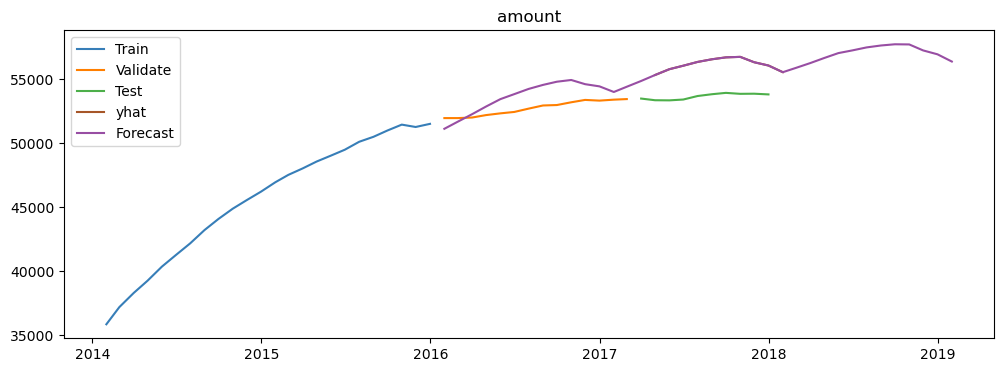

In [74]:
for col in train.columns:
    final_plot(col)